In [108]:
import pandas as pd
import numpy as np
from string import punctuation
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import LSTM, concatenate, TextVectorization, Input, BatchNormalization, Dense, Embedding, Reshape, Dropout, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pdude\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
df = pd.read_csv('data.csv', header=0)
df = df.dropna(axis=0)
df['question1'] = df['question1'].astype('str')
df['question2'] = df['question2'].astype('str')
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


<AxesSubplot:>

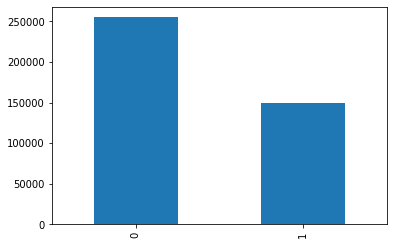

In [58]:
df['is_duplicate'].astype('category').value_counts().plot(kind='bar')

In [59]:
def clean(text):
    text = text.lower()

    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    stops = set(stopwords.words("english"))
    text = text.split()
    stemmer = SnowballStemmer('english')
    text = [w for w in text if not w in stops]
    text = [stemmer.stem(word) for word in text]
    text = " ".join(text)

    return(text)

In [60]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guid invest share market india,step step guid invest share market,0
1,1,3,4,stori kohinoor koh - - noor diamond,would happen indian govern stole kohinoor koh ...,0
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dns,0
3,3,7,8,mental lone solv,find remaind math 23 ^ 24 math divid 24 23,0
4,4,9,10,one dissolv water quik sugar salt methan carbo...,fish would surviv salt water,0
...,...,...,...,...,...,...
404285,404285,433578,379845,mani keyword racket program languag latest ver...,mani keyword perl program languag latest version,0
404286,404286,18840,155606,believ life death,true life death,1
404287,404287,537928,537929,one coin,coin,0
404288,404288,537930,537931,approx annual cost live studi uic chicago indi...,littl hairfal problem want use hair style prod...,0


In [116]:
X = df[['question1', 'question2']].values
y = LabelEncoder().fit_transform(df['is_duplicate'].values)

print(X.shape)

(404287, 2)


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

(270872, 2)
(133415, 2)


In [118]:
texts_train = np.concatenate((X_train[:,0], X_train[:,1]))

tokenizer = Tokenizer(num_words=3000, lower=True)

tokenizer.fit_on_texts(texts_train)

In [119]:
X_train_q1 = tokenizer.texts_to_matrix(X_train[:,0], mode='tfidf')
X_train_q2 = tokenizer.texts_to_matrix(X_train[:,1], mode='tfidf')

In [129]:
input_1 = Input((X_train_q1.shape[1],))
reshape_1 = Reshape((1, X_train_q1.shape[1]))(input_1)
lstm_1_1 = LSTM(128, activation='relu', return_sequences=True, recurrent_dropout=0.4, dropout=0.4)(reshape_1)

input_2 = Input((X_train_q2.shape[1],))
reshape_2 = Reshape((1, X_train_q2.shape[1]))(input_2)
lstm_2_1 = LSTM(128, activation='relu', return_sequences=True, recurrent_dropout=0.4, dropout=0.4)(reshape_2)

merged = concatenate([lstm_1_1, lstm_2_1])
merged = Dropout(0.4)(merged)
merged = BatchNormalization()(merged)

merged = LSTM(128, activation='relu', recurrent_dropout=0.4, dropout=0.4)(merged)
merged = Dropout(0.4)(merged)
merged = BatchNormalization()(merged)

merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.4)(merged)
merged = BatchNormalization()(merged)

merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.4)(merged)
merged = BatchNormalization()(merged)

output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [130]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 3000)]       0           []                               
                                                                                                  
 input_66 (InputLayer)          [(None, 3000)]       0           []                               
                                                                                                  
 reshape_72 (Reshape)           (None, 1, 3000)      0           ['input_65[0][0]']               
                                                                                                  
 reshape_73 (Reshape)           (None, 1, 3000)      0           ['input_66[0][0]']               
                                                                                           

In [131]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

hist = model.fit([X_train_q1, X_train_q2], y_train, validation_split=0.2, epochs=30, batch_size=512, callbacks=[early_stopping])

Epoch 1/30
424/424 [==============================] - 61s 137ms/step - loss: 0.6586 - accuracy: 0.6046 - val_loss: 0.6671 - val_accuracy: 0.5191
Epoch 2/30
424/424 [==============================] - 61s 144ms/step - loss: 0.5833 - accuracy: 0.6901 - val_loss: 0.5655 - val_accuracy: 0.7166
Epoch 3/30
424/424 [==============================] - 59s 140ms/step - loss: 0.5558 - accuracy: 0.7175 - val_loss: 0.5462 - val_accuracy: 0.7308
Epoch 4/30
424/424 [==============================] - 59s 138ms/step - loss: 0.5423 - accuracy: 0.7270 - val_loss: 0.5352 - val_accuracy: 0.7358
Epoch 5/30
424/424 [==============================] - 61s 144ms/step - loss: 0.5328 - accuracy: 0.7333 - val_loss: 0.5276 - val_accuracy: 0.7394
Epoch 6/30
424/424 [==============================] - 59s 139ms/step - loss: 0.5259 - accuracy: 0.7385 - val_loss: 0.5240 - val_accuracy: 0.7382
Epoch 7/30
424/424 [==============================] - 59s 139ms/step - loss: 0.5181 - accuracy: 0.7437 - val_loss: 0.5229 - val_ac

In [132]:
import matplotlib.pyplot as plt

def draw_plot(name, model):
    plt.figure(figsize=(16, 8))

    plt.suptitle(name, fontsize=14, fontweight='bold')

    ax1 = plt.subplot(1, 2, 1)
    plt.plot(model.history.history['loss'][0:], label='train')
    plt.plot(model.history.history['val_loss'][0:], label='validiation')

    ax1.legend(fontsize=13)
    ax1.set_xlabel('epochs', fontsize=14)
    ax1.set_ylabel('loss', fontsize=14)
    #ax1.set_xlim([0, 18])
    #ax1.set_xticks([0, 3, 8, 13, 18])
    #ax1.set_xticklabels([2, 5, 10, 15, 20])
    ax1.tick_params(axis="x", labelsize=14)
    ax1.tick_params(axis="y", labelsize=14)

    ax2 = plt.subplot(1, 2, 2)
    plt.plot(model.history.history['accuracy'][0:], label='train')
    plt.plot(model.history.history['val_accuracy'][0:], label='validiation')

    ax2.legend(fontsize=13)
    ax2.set_xlabel('epochs', fontsize=14)
    ax2.set_ylabel('accuracy', fontsize=14)
    ax2.tick_params(axis="x", labelsize=14)
    ax2.tick_params(axis="y", labelsize=14)
    #ax2.set_xlim([0, 18])
    #ax2.set_xticks([0, 3, 8, 13, 18])
    #ax2.set_xticklabels([2, 5, 10, 15, 20])

    plt.show()

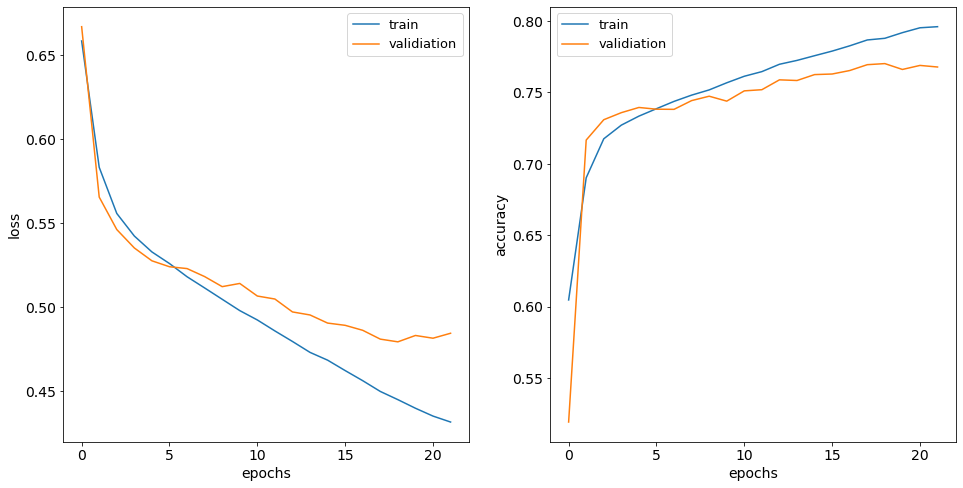

In [133]:
draw_plot('', model)

In [134]:
X_test_q1 = tokenizer.texts_to_matrix(X_test[:,0], mode='tfidf')
X_test_q2 = tokenizer.texts_to_matrix(X_test[:,1], mode='tfidf')

In [135]:
pred = model.evaluate([X_test_q1, X_test_q2], y_test, batch_size=512)

261/261 [==============================] - 11s 41ms/step - loss: 0.4852 - accuracy: 0.7689
